In [417]:
import numpy as np
import torch

In [418]:
torch.manual_seed(0)
from torchvision import transforms
import torch.nn.functional as F 
from torch import nn
import sys

sys.path.insert(1, '/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/visualisation')
import json_ImExport
import LogDataImport

data=json_ImExport.loadData("/Users/leonkiesgen/Documents/Python/Kappa_variation_vmax100.json")

data2=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_01/15_00_59_data.csv")


mean, std = (0.5), (0.5)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])




In [419]:
class FMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(99,300)
        self.fc2 = nn.Linear(300,200)
        self.fc3 = nn.Linear(200,150)
        self.fc4 = nn.Linear(150,98)

    def forward(self,x):

        x = F.leaky_relu(self.fc1(x),negative_slope=0.05)
        x = F.leaky_relu(self.fc2(x),negative_slope=0.05)
        x = F.leaky_relu(self.fc3(x),negative_slope=0.05)
        x = F.leaky_relu(self.fc4(x),negative_slope=0.05)
        

        return x

In [548]:
import random
model=FMNIST()

class Normalize():

    def __init__(self,data,scale=None):


        if scale is None:
            self.max=np.max(np.abs(data))
        else:
            self.max=scale
        print("Max is: ",self.max )

    def __call__(self,x):
        return x/self.max

    def normal(self,x):
        return x*self.max


def prepareData(data):
    
    prepareddata=[]
    for item in data:
        inpdata=[]
        #print(item)
        #print(item["v_ini"])
        inpdata.append(item["v_ini"])
        inpdata.append(item["v_max"])
        inpdata.append(item["Power"])   
        inpdata.extend(item["Kappa"])

        #print("Input: ",inpdata)
        label=item["V_op"]

        inpdata=torch.Tensor(inpdata)
        label=torch.Tensor(label)

        tupledata=(inpdata,label)
        prepareddata.append((inpdata,label))
    

    return prepareddata


def prepareLogData(data):
    lowestLen=200
    prepareddata=[]

    allkappa=[]
    for item in data:
        allkappa.extend(item[0])
    
    #Initialize Nomalizer
    kappaNormalize=Normalize(allkappa)
    VelNormalize=Normalize(None,scale=70)

    for item in data:
        inpdata=[]
        lowestLen= len(item[1]) if len(item[1])< lowestLen else lowestLen

        
        inpdata.append(VelNormalize(item[1][0]))#item["v_ini"])
        #print("Item 1: ", inpdata)
        #inpdata.append()#item["v_max"])
        #inpdata.append()#item["Power"]) 

        kappatmp=kappaNormalize(item[0][:98])
        inpdata.extend(kappatmp) #Kappa
        



        inpdata=torch.Tensor(inpdata)

        label=np.array(item[1][:98])

        label=torch.Tensor(VelNormalize(label)) #V_opt

        

        tupledata=(inpdata,label)
        prepareddata.append((inpdata,label))
    
    print(lowestLen)
    return prepareddata

traindata=prepareLogData(data2)
random.shuffle(traindata)
#print(traindata[1000][1])
#print(len(traindata))

Max is:  0.044784975560085524
Max is:  70
98


In [422]:
from IPython.core.debugger import set_trace

from torch import optim
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

OUTSHOW=None

num_epochs = 5000
train_tracker, test_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0
    cum_loss2 = 0
    random.shuffle(traindata)
    
    for batch, (inp, vel) in enumerate(traindata,1):


        optimizer.zero_grad()
        output = model(inp)

        

        loss = criterion(output, vel)

        loss.backward()
        optimizer.step()

        cum_loss += loss.item()
        

    train_tracker.append(cum_loss/len(traindata))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss2/len(traindata)} | " ,end="")
    
    test_loss = 0
    num_correct = 0
    total = 0
    
    for batch, (inp, vel) in enumerate(traindata,1):
        
        output3 = model(inp)
        batch_loss = criterion(output3, vel)        
        test_loss += batch_loss.item()
    
        
    
    test_tracker.append(test_loss/len(traindata))
    print(f"Test loss: {test_loss/len(traindata)} | ")
    '''
    #accuracy_tracker.append(num_correct/total)
    #print(f'Accuracy : {num_correct/total}')     
    

#print(f'\nNumber correct : {num_correct}, Total : {total}')
#print(f'Accuracy of the model after 30 epochs on the 10000 test images: {num_correct * 100 / total}% ')
    '''
    

g loss: 0.0 |Test loss: 0.001157121011887101 | 
Epoch(4734/5000) | Training loss: 0.0 |Test loss: 0.0012329778488632142 | 
Epoch(4735/5000) | Training loss: 0.0 |Test loss: 0.001198997159854305 | 
Epoch(4736/5000) | Training loss: 0.0 |Test loss: 0.001131741061658322 | 
Epoch(4737/5000) | Training loss: 0.0 |Test loss: 0.0014243349245793822 | 
Epoch(4738/5000) | Training loss: 0.0 |Test loss: 0.0013145439900900944 | 
Epoch(4739/5000) | Training loss: 0.0 |Test loss: 0.0011885422426122095 | 
Epoch(4740/5000) | Training loss: 0.0 |Test loss: 0.0012817977887527947 | 
Epoch(4741/5000) | Training loss: 0.0 |Test loss: 0.0017637278019814301 | 
Epoch(4742/5000) | Training loss: 0.0 |Test loss: 0.001213685551673282 | 
Epoch(4743/5000) | Training loss: 0.0 |Test loss: 0.0011379097192008624 | 
Epoch(4744/5000) | Training loss: 0.0 |Test loss: 0.0012586793505997766 | 
Epoch(4745/5000) | Training loss: 0.0 |Test loss: 0.0014018125736070762 | 
Epoch(4746/5000) | Training loss: 0.0 |Test loss: 0.001

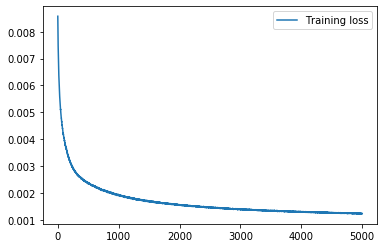

In [423]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
#plt.plot(test_tracker, label='Test loss')
plt.legend()

In [549]:
def predict(testexample,NN=model):
    VelNormalize= Normalize(None,70)

    criterion = nn.L1Loss()
    pData=testexample[0]
    pred=NN(pData[0])
    loss=criterion(pred,pData[1])

    %matplotlib inline


    pred=VelNormalize.normal(np.array(pred.tolist()))
    real=VelNormalize.normal(np.array(pData[1]))

    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    print("Loss:", loss.item())

from sklearn.metrics import r2_score
def r2Score(example,NN=model):
    
    PRED=[]
    REAL=[] 
    for (inp,label) in example:
        optimizer.zero_grad()
        pred=model(inp)
        PRED.append(pred.tolist())
        REAL.append(label.tolist())


    SCORE=r2_score(PRED,REAL,multioutput='variance_weighted')
    return SCORE

Max is:  70
Evolived Time:  0.002254962921142578
Loss: 0.001009225845336914
The Score of the Train Dataset is:  0.9983019507406327 %


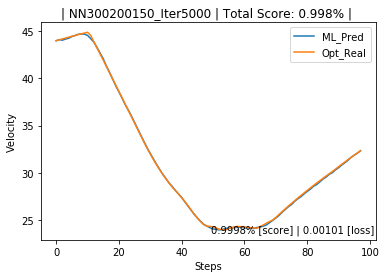

In [585]:
#The Visualisation
import time
NR=615

VelNormalize= Normalize(None,70)

criterion = nn.L1Loss()

testdata=torch.clone(traindata[NR][0])
#testdata=traindata[NR][0]
#testdata[0]=0.5


t1=time.time()
pred=model(testdata)
t2=time.time()

print("Evolived Time: " , (t2-t1)*1000)

loss=criterion(pred,traindata[NR][1])



%matplotlib inline

pred=VelNormalize.normal(np.array(pred.tolist()))
real=VelNormalize.normal(np.array(traindata[NR][1]))

Score=r2Score(traindata)

plt.plot(pred,label="Pred")
plt.plot(real,label= "Real_Optimizer")

plt.legend(["ML_Pred","Opt_Real"])
plt.title("| "+name + " | Total Score: "+str(np.round(Score,3))+"%"+ " | " )
plt.xlabel("Steps")
plt.ylabel("Velocity")

predItem=model(traindata[NR][0]).tolist()
scoreItem=r2_score(predItem,traindata[NR][1])
text= str(np.round(scoreItem,4))+ "% [score] | "+str(np.round(loss.item(),5)) +" [loss] "
MIN=min(pred)
plt.text(76,MIN,text,horizontalalignment='center',verticalalignment='center')
print("Loss:", loss.item())


print("The Score of the Train Dataset is: ",Score,"%")

In [ ]:
%matplotlib inline

plt.plot(model.forward(traindata[1200][0]).tolist())
plt.plot(OUTSHOW.tolist(),label="Pred")
plt.plot(traindata[1200][1].tolist(),label= "Real_Optimizer")

In [551]:
name="NN300200150_Iter5000"
save=False

In [425]:
#Save MODEL
if save
    PATH="/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/mlModels/"+ name
    torch.save(model.state_dict(), PATH+".pt")
    torch.save(model,PATH+".pth")

/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FMNIST. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [553]:
#Load MODEL with same Structure
model=FMNIST()
model.load_state_dict(torch.load(PATH+".pt"))
model.eval()

FMNIST(
  (fc1): Linear(in_features=99, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=150, bias=True)
  (fc4): Linear(in_features=150, out_features=98, bias=True)
)

In [ ]:
#Load MODEL with different Structure
model2=torch.load(PATH+".pth")
model2.eval()

In [ ]:
model2(traindata[37][0])